# OAM SEMSANS Experiment:
***

This notebook contain some theorectical calculations, McStas simulations, and the principle data analysis for the "Demonstration of orbital angular momentum in neutron beams" experiment at the HFIR at ORNL. This experiment will begin July 31st, 2023 at the HB-2D polarized development beamline during fuel cycle 502.

## Constants and functions

In [1]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib import cm
import mcstasscript as ms
#import scienceplots
import math,csv
from scipy.optimize import curve_fit,minimize
from scipy.signal import hilbert,convolve,find_peaks
from scipy.fft import fft,fftfreq,ifft
from scipy.integrate import quad,simpson
from scipy.interpolate import CubicSpline
from os.path import isdir,isfile

#plt.style.use(['science', 'notebook', 'grid', 'default', 'bright'])
plot_height = 8
plot_width = plot_height*1.618

#np.set_printoptions(suppress=False,precision=5)
np.set_printoptions(suppress=True)

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 15,20,25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)
#plt.rcParams.update({'axes.grid':True})

plt.rc('text', usetex=False)
if False: #Additions to latex preamble for matplotlib:
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsthm,amssymb,amsfonts,braket,siunitx}')
    plt.rcParams["font.family"] = "Computer Modern Roman"
    sym.init_printing()

LAM = 4.25  #HB-2D wavelength
DLAM = LAM*1/100  #HB-2D wavelength spread
GPA = 35.
gn = -1.832471e8  #gyromagnetic ratio of neutron (rad/T/m^2)
mn = 1.674927e-27  #mass of neutron (kg)
hbar = 1.054571e-34  #plancks constant (kg m^2/s)
cln = gn/(hbar*2*np.pi)*mn  #Larmor constant (SI units)
cl = gn/(hbar*2*np.pi)*mn*1e-14  #Larmor phase constant (G^-1 m^-1 AA^-1)
print(f'Larmor constant = {round(cl,3)} (G^-1 m^-1 AA^-1)')

Larmor constant = -4.632 (G^-1 m^-1 AA^-1)


In [43]:
def get_period(I1,I2,gpa=GPA,lam=LAM,show=False):
    """Returns SEMSANS period for the MWPs."""
    assert I2 > I1, 'Second MWP current must be larger than the first!'
    result = np.pi/(cl*gpa*lam*(I1-I2))
    if show: print(f'Period: {np.round(result*1e3,2)} mm')
    return result

def get_sem(B1,L1,L2,show=False):
    """Returns focusing condition for prism in regular SEMSANS."""
    assert L1 >= L2, 'L1 > L2!'
    result = B1*L1/L2
    if show: print(f'SEMSANS focused current: {round(result,2)} amps')
    return result

def get_ch(B1,L1,L2,L3,L4,show=False):
    """Returns focusing conditions for 4 MWPs in checkerboard SEMSANS."""
    assert L1 >= L2 or L2 >= L3 or L3 >= L4, 'Distances must be in strict descending order!'
    result = np.array([-B1*L1/L2, B1*(L1 - L2)/(L3 - L4)*L4/L2, -B1*(L1 - L2)/(L3 - L4)*L3/L2])
    if show: print(f'2D SEMSANS focused current: {np.round(result,2)} amps')
    return result

def cos(x,*args,**kwargs):
    """Returns a cosine with parameters determined by ().
    Standard argument list is ampitude,frequency,phase,shim."""
    assert len(args) + len(kwargs) == 4, 'Must specify 4 parameters: amp, freq, phase, and shim!'
    i=0
    if 'amp' in kwargs: amp = kwargs.get('amp')
    else:
        amp = args[i]
        i += 1
    if 'freq' in kwargs: freq = kwargs.get('freq')
    else:
        freq = args[i]
        i += 1
    if 'phase' in kwargs: phase = kwargs.get('phase')
    else: 
        phase = args[i]
        i += 1
    if 'shim' in kwargs: shim = kwargs.get('shim')
    else: 
        shim = args[i]
    return amp*np.cos(freq*x + phase) + shim

def get_flip(dist,gpa=30.,lam=LAM,flip=np.pi,show=True):
    """Returns the current required for pi or pi/2 flip."""
    result = round(flip/(cl*gpa*lam*dist*1e-2),2)
    if show: print(f'Current required for a {round(flip,2)} flip: {result} amps')
    return result

def frp_convert(value,show=False):
    """Convert polarization to flipping ratio and vice-versa."""
    assert value != 1, 'FR is infinite when polarization is unity!'
    if value > 1:
        result = (value - 1)/(value + 1)
        something = f'FR: {round(value,3)} \n Pol: {round(result*100,1)}%'
    else:
        result = (1 + value)/(1 - value)
        something = f'FR: {round(result,3)} \n Pol: {round(value*100,1)}%'
    if show: print(something)
    return result

In [3]:
LM1 = 1.5
LM2 = 1.09

L1 = LM1 + .047
L2 = LM1 - .063

L3 = LM2 + .067
L4 = LM2 - .045

B1 = 9.29
_ = get_period(B1,get_sem(B1,L1,L2,show=True),show=True)
_ = get_ch(B1,1.5,1.5-.13,1.09+.07,1.09-.07,show=True)

SEMSANS focused current: 10.0 amps
Period: 6.41 mm
2D SEMSANS focused current: [-10.17   6.42  -7.3 ] amps


In [48]:
B1 = 100
L1 = 3
L2 = 1
_ = get_period(B1,get_sem(B1,L1,L2,show=True),show=True)

SEMSANS focused current: 300.0 amps
Period: 0.02 mm


## Building the beamline

In [ ]:
lambda0 = 4.25  #Mean wavelength (AA)
dlambda = lambda0*1/100

ap_width = 10.
ap_height = 10.

MWP_str = 6e-3  #MWP field strength (T/Amp)
NU_str = 1e-3
CRYO_str = 1e-3

MWP_dims = [.02,.02,.11]
NU_dims = [.03,.03,.03]
CRYO_dims = [.03,.03,.015]

MWP_sep = .006
NU_sep = .0125 + .015
CYRO_sep = .006

N1 = .15
C1 = N1 + NU_dims[2] + NU_sep
d1 = C1 + CRYO_dims[2] + CYRO_sep
d2 = d1 + MWP_dims[2] + MWP_sep
N2 = d2 + MWP_dims[2] + NU_sep
d3 = N2 + NU_dims[2] + NU_sep
d4 = d3 + MWP_dims[2] + MWP_sep
C2 = d4 + MWP_dims[2] + CYRO_sep
N3 = C2 + CRYO_dims[2] + NU_sep
det1 = N3 + NU_dims[2] + .15    #distance from sample position to detector1 (m)
ds = det1 + .3
det2 = ds + .6  #must be shorter than 3 meters
d = [N1,C1,d1,d2,N2,d3,d4,C2,N3,det1,ds,det2]

print(MWP_dims[2]*2+MWP_sep+CYRO_sep+CRYO_dims[2]+2*NU_sep)

print(f'Wavelength: {lambda0} p/m {round(dlambda,3)}')
print(f'Aperture (mm) = {ap_width,ap_height}')
print(f'Front distances from MWP to source (m): {np.round(d,3)}')

cur = get_sec(sel=100)
print(f'MWP currents: {cur}')

pol_dir = [1,0,0]    #direction of polarizer (x,y,z)
pol_dir = [i/np.sqrt(sum([j**2 for j in pol_dir])) for i in pol_dir]    
print('Polarizer axis: ', [round(i,3) for i in pol_dir])

det_x,det_y = 10.,10.
det_bins = 128

print(f'Detector size (mm): {np.round([det_x,det_y],3)}')
print('[x,y] bin size (mm) = ', [round(i,3) for i in [det_x/det_bins,det_y/det_bins]], '\n')

print("-"*80)     #Start of instrument definition
OAM = ms.McStas_instr('OAM', author = 'Sam McKay', origin = 'Indiana University')
delta_lambda = OAM.add_parameter("double", "delta_lambda", value = dlambda, comment="Wavelength spread [AA]")
low_count = OAM.add_parameter("int", "low_count", value = 0, comment="if true flips analyzer direction [N/A]")
all_off = OAM.add_parameter("int", "all_off", value = 0, comment="if true turns off all MWPs [N/A]")
cur1 = OAM.add_parameter("double", "cur1", value = cur, comment="MWP1 current [Amps]")
cur2 = OAM.add_parameter("double", "cur2", value = -cur, comment="MWP2 current [Amps]")
cur3 = OAM.add_parameter("double", "cur3", value = cur, comment="MWP3 current [Amps]")
cur4 = OAM.add_parameter("double", "cur4", value = -cur, comment="MWP4 current [Amps]")
polx = OAM.add_parameter("double", "polx", value = pol_dir[0], comment="x-component of polarizer [N/A]")
poly = OAM.add_parameter("double", "poly", value = pol_dir[1], comment="y-component of polarizer [N/A]")
polz = OAM.add_parameter("double", "polz", value = pol_dir[2], comment="z-component of polarizer [N/A]")
OAM.show_parameters()

print("-"*80)    #Source and polarizer (collimation included via source parameters):
OAM.add_component("origin","Progress_bar")
OAM.add_component("arm","Arm", AT=[0,0,0], RELATIVE="origin")

src = OAM.add_component("src","Source_sam", AT=[0,0,0], RELATIVE="origin")
src.set_parameters(xwidth=ap_width*1e-3,yheight=ap_height*1e-3,I1=1e13,lambda0=lambda0,dlambda="delta_lambda",\
                   focus_xw=det_x/1e3,focus_yh=det_y/1e3,x_offset=det_x_offset/1e3,dist=Ld)
print(src)
pol = OAM.add_component("pol","Set_pol", AT=[0,0,1e-6], RELATIVE="origin")
pol.set_parameters(px="polx", py="poly", pz="polz")

print(pol)

print("-"*80)    #First accelerator coil and nutator
NU1 = OAM.add_component("NU1","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
NU1.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(NU1)
AC1 = OAM.add_component("AC1","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
AC1.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(AC1)

print("-"*80)    #Magnetic Wollaston prisms:
MWP1 = OAM.add_component("MWP1","pol_MWP_FI_expansion_v2", AT=[0,0,d[0]], RELATIVE="origin")
MWP1.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur1*(1-all_off)")
MWP2 = OAM.add_component("MWP2","pol_MWP_FI_expansion_v2", AT=[0,0,d[1]], RELATIVE="origin")
MWP2.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur2*(1-all_off)")
MWP3 = OAM.add_component("MWP3","pol_MWP_FI_expansion_v2", AT=[0,0,d[2]], RELATIVE="origin")
MWP3.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur3*(1-all_off)")
MWP4 = OAM.add_component("MWP4","pol_MWP_FI_expansion_v2", AT=[0,0,d[3]], RELATIVE="origin")
MWP4.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur4*(1-all_off)")
MWP1.set_ROTATED([0, 0, 0], RELATIVE="ABSOLUTE")
MWP2.set_ROTATED([0, 0, 0], RELATIVE="ABSOLUTE")
MWP3.set_ROTATED([0, 0, 90], RELATIVE="ABSOLUTE")
MWP4.set_ROTATED([0, 0, 90], RELATIVE="ABSOLUTE")
print(MWP1,'\n', MWP2)
print(MWP3, '\n', MWP4)

print("-"*80)    #Second accelerator coil and nutator
AC2 = OAM.add_component("AC2","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
AC2.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(AC2)
NU2 = OAM.add_component("NU2","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
NU2.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(NU2)

print("-"*80)    #Detectors and sample:
ana = OAM.add_component("ana","PolAnalyser_ideal", AT=[0, 0, Ld - (Ls + 2e-6)], RELATIVE="origin")
ana.set_parameters(mx=0, my=0, mz="polx*(1-2*low_count)")
ana.set_ROTATED([0, 0, 0], RELATIVE="ABSOLUTE")
print(ana)

twoD_det = OAM.add_component("twoD_det","PSD_monitor", AT=[det_x_offset/1e3, 0, Ld + 2e-6], RELATIVE="origin")
twoD_det.set_parameters(nx=det_bins, ny=det_bins, filename=twoD_file, xwidth=det_x*1e-3, yheight=det_y*1e-3)
print(twoD_det)

print("-"*80)    #Final instrument summary:
OAM.show_components()

## Simulation scans

In [ ]:
def do_run(ray_num, curs):
    """Runs the two necessary simulations to extract the polarization.
    Returns high and low counts and errors and all used currents."""
    used_curs = []
    hc_runs, hc_err = [[],[]]
    lc_runs, lc_err = [[],[]]

    for i in curs:
        c1 = i
        c2, c3, c4 = get_ch(i, L1, L2, L3, L4)
        used_curs.append([c1,c2,c3,c4])
        print('Currents = ', [round(i,3) for i in [c1,c2,c3,c4]])

        OAM.settings(output_path='OAM_hc_'+str(round(c1,2)), ncount=ray_num)
        low_count.value, all_off.value, cur1.value, cur2.value, cur3.value, cur4.value = 0, 0, c1, c2, c3, c4
        OAM_hc = OAM.backengine()
        hc_runs.append(OAM_hc[-1].Intensity)    #only LAST detector is returned
        hc_err.append(OAM_hc[-1].Error)
        ms.make_plot(OAM_hc)

        OAM.settings(output_path='OAM_lc_'+str(round(c1,2)))
        low_count.value = 1
        OAM_lc = OAM.backengine()
        lc_runs.append(OAM_lc[-1].Intensity)
        lc_err.append(OAM_lc[-1].Error)
        ms.make_plot(OAM_lc)
        print('='*80, '\n')
    return used_curs, hc_runs, hc_err, lc_runs, lc_err
        
used_curs, hc_runs, hc_err, lc_runs, lc_err = do_run(1e7, [10,40])


## Simulation Analysis
***

In [ ]:
xpos = np.linspace(-det_x/2,det_x/2, num=det_bins, endpoint=True)
fine_bins = 200
finer_bins = 1000
xpos_fine = np.linspace(xpos[0], xpos[-1], num=fine_bins, endpoint=True)
xpos_finer = np.linspace(xpos[0], xpos[-1], num=finer_bins, endpoint=True)
pols = np.array([np.zeros((det_bins,det_bins)) for i in range(len(hc_runs))])

for i in range(len(used_curs)): #don't change this!
    for j in range(det_bins):
        for k in range(det_bins):
            pols[i][j][k] = ((hc_runs[i][j][k] - lc_runs[i][j][k])\
                             /(hc_runs[i][j][k] + lc_runs[i][j][k]))
                
    fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('Pol. with B1 ='+str(used_curs[i][0]))
    plt.imshow(pols[i], origin='lower', vmin=-1, vmax=1, interpolation='none', cmap='bwr')
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    ax.set_xticks(np.linspace(0,det_bins-1,7))
    ax.set_yticks(np.linspace(0,det_bins-1,7))
    ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
    ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
    plt.colorbar()
    plt.show()


In [ ]:
x_mg, y_mg = np.meshgrid(xpos, xpos)
def cb_theory(x,y,p):
    """Generates theorectical checkerboard spin-texture."""
    r_0 = p/(np.pi)
    z = -2*np.cos(2*y/r_0)*np.cos(x/r_0)*np.sin(x/r_0)
    return z

def get_p(c):
    """Returns theorectical fringe period."""
    return abs(2*np.pi/(cL*lambda0*MWP_str*(c[0] + c[1])))*1e3
cb_th = cb_theory(x_mg,y_mg,get_p(used_curs[-1]))

plot_im, plot_3D = True, False

if plot_im:
    """fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('Theory')
    plt.imshow(cb_th, origin='lower', vmin=-1, vmax=1,interpolation='none', cmap='bwr')
    plt.colorbar()
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    ax.set_xticks(np.linspace(0,det_bins-1,7))
    ax.set_yticks(np.linspace(0,det_bins-1,7))
    ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
    ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
    plt.show()"""

    fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('McStas Simulated Polarization')
    plt.imshow(pols[-1], origin='lower', vmin=-1, vmax=1, interpolation='none', cmap='bwr')
    plt.colorbar()
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    ax.set_xticks(np.linspace(0,det_bins-1,7))
    ax.set_yticks(np.linspace(0,det_bins-1,7))
    ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
    ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
    #plt.axhline(y=63.5, linewidth=5, linestyle='--', color='green')
    #plt.axvline(x=69.25, linewidth=5, linestyle='--', color='purple')
    plt.show()

    fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('McStas Polarization Slices')
    plt.plot(xpos, pols[-1][64,:], 'o', ms=15, color='green', zorder=10, markerfacecolor='none', markeredgewidth=5)
    guess = [(np.max(pols[-1][64,:])-np.min(pols[-1][64,:]))/2.,2*np.pi/1,0,np.mean(pols[-1][64,:])]
    fit, cov = sp.optimize.curve_fit(simple_cos, xpos, pols[-1][64,:], p0=guess)
    plt.plot(xpos, simple_cos(xpos, *fit), '-', linewidth=6, color='green', label='Horizontal Fit')
    
    plt.plot(xpos, pols[-1][:,69], 'o', ms=15, color='purple', zorder=15, markerfacecolor='none', markeredgewidth=5)
    guess = [(np.max(pols[-1][:,69])-np.min(pols[-1][:,69]))/2.,2*np.pi/1,0,np.mean(pols[-1][:,69])]
    fit, cov = sp.optimize.curve_fit(simple_cos, xpos, pols[-1][:,69], p0=guess)
    plt.plot(xpos, simple_cos(xpos, *fit), '-', linewidth=6, color='purple', label='Vertical Fit')
    
    plt.xlabel('x [mm]')
    plt.ylabel('Polarization')
    plt.legend(loc='lower left', framealpha=1).set_zorder(20)
    plt.grid()
    plt.show()
    
if plot_3D:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    #ax.view_init(60, 35)
    ax.contour3D(xpos,xpos,pols[0], 100, cmap='plasma')
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x_mg,y_mg,cb_th, rstride=1, cstride=1, cmap='plasma', edgecolor='none')
    plt.show()


In [ ]:
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
plt.title('Polarization vs position')
plt.plot(xpos,pols[1,5,:], linewidth=5, label='McStas')
plt.plot(xpos, -cb_theory(xpos,xpos[5],get_p(used_curs[1])), linewidth=5, label='Quantum')
ax.set_ylim(-1,1)
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
plt.title('Polarization vs position')
plt.plot(xpos,pols[1,:,45], linewidth=5, label='McStas')
plt.plot(xpos, -cb_theory(xpos[45],xpos,get_p(used_curs[1])), linewidth=5, label='Quantum')
ax.set_ylim(-1,1)
plt.legend()
plt.grid()
plt.show()


## Experiment Data Analysis:
***

In [64]:
DEFAULT_DIRECT = 'C://Users//samck//Desktop//SEMSANS//'
assert isdir(DEFAULT_DIRECT), 'Default directory is not found!'
print(f'Default directory: {DEFAULT_DIRECT}')

def fumi_reader(run_num,direct=DEFAULT_DIRECT,plot=False,ROI_x=(100,400),ROI_y=(100,400)):
    """Reads and plots the csv datafile. Can specify a region of interest with ROI."""
    filename = direct + f'Run_{run_num}_DSCALE_2_ROT_90.0.txt'
    #print(f'Run number used: {run_num}')
    assert isdir(direct), f'Data directory {direct} is not found!'
    assert isfile(filename), f'Datafile {filename} is not found!'
    
    with open(filename) as f:
        lines = csv.reader(f,delimiter=',')
        data = np.array([l for l in lines],dtype=float)[ROI_x[0]:ROI_x[1],ROI_y[0]:ROI_y[1]].T
    if plot: ShowImage(data,title=f'{run_num}')
    return data

def ShowImage(inImage,vmin=0,title=''):
    """Plots image in reduction function."""
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_title(title)
    im = ax.imshow(inImage,origin="lower",aspect="auto",vmin=vmin,vmax=np.max(inImage))
    fig.colorbar(im)
    fig.tight_layout()
    plt.show()

Default directory: C://Users//samck//Desktop//SEMSANS//


#### 8/5 Analyzing last night's transverse OAM scan after adjusting the v-vavity position and rotation

We decided to choose the position with the most counts thinking that it would probably be the position of highest contrast. However, we are probably going through the center of the vcavity, so there are 2 aberrations from the channels. We decided on the cav_trans position given by scans 6279-6280 from yesterday. (-9 mm on the old coordinates, NOT re-zeroed.)

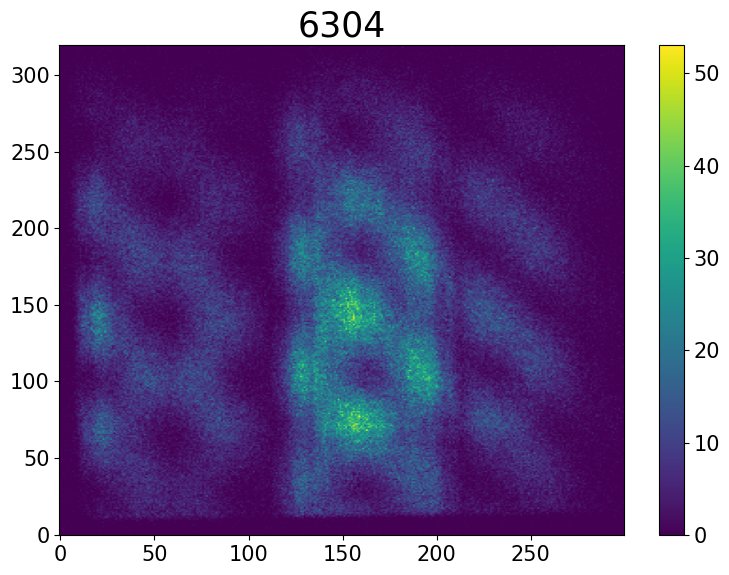

In [74]:
Rx=(90,390)
Ry=(80,400)
_ = fumi_reader(6304,plot=True,ROI_x=Rx,ROI_y=Ry)

In [75]:
start = 6304
end = 6357  #not included
scans = [fumi_reader(i,plot=False,ROI_x=Rx,ROI_y=Ry) for i in range(start,end)]    

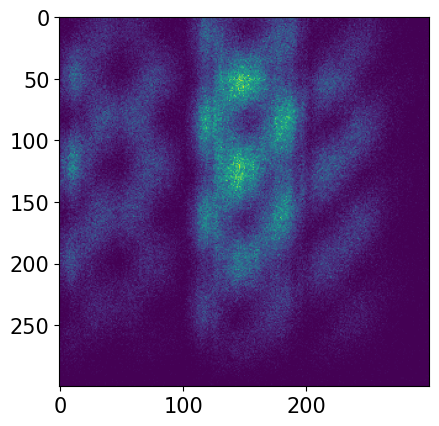

In [57]:
plt.imshow(scans[0])